# Tutorial08: Graph Neural Networks (GNN)
> Created Aug. 2024 for the FSU Course: *Machine Learning in Physics* <br>
> H. B. Prosper<br>


## Introduction
In this tutorial we build a **graph neural network** (GNN) similar to the one developed in the award-winning work by the IceCube Collaboration[1] which yielded state-of-the-art results in neutrino event classification.

In mathematics, a **graph** is a tuple $G = (V, E)$ of two sets $V = \{v_1,\cdots\}$ and $E = \{e_1,\cdots\}$ where $V$ is a set of **vertices** (or nodes) connected by **edges** that form a set $E$.
<img src="./graph.png" align="left" width="250px"/> Graphs are closely related to **point clouds**, which is literally a cloud of points in some vector space. In this tutorial, each data instance is a point cloud $P = \{ (p_T, \eta, \phi)_i \}_{i=1}^n \in \mathbb{R}^d$, where $d = 3$ and where, in general, the number of points $n$ varies from one point cloud to the next. The subset of data used in this tutorial come from the website [LHC Olympics 2020](https://lhco2020.github.io/homepage/), which you should consult for a detailed description of the particle collision events. 

Because the number of points varies from one point cloud to the next, we shall train the GNN with a batch size of one.
<br clear="left"/>


## References
  1. N. Choma et al. IceCube collaboration, Graph Neural Networks for IceCube Signal Classification,  arXiv:1809.06166v1.

## Tips

  * Use __esc r__ to disable a cell
  * Use __esc y__ to reactivate it
  * Use __esc m__ to go to markdown mode. **Markdown** is the typesetting language used in jupyter notebooks.
  * In a markdown cell, double tap the mouse or glide pad (on your laptop) to go to edit mode. 
  * Shift + return to execute a cell (including markdown cells).
  * If the equations don't typeset, try double tapping the cell again, and re-execute it.

In [1]:
# standard system modules
import os, sys
sys.path.append('../../python')

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# module to access data in Hierarchical Data Format (HDF or H5 format)
import h5py

# to reimport Python modules
import importlib

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from lossmonitor import TimeLeft

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn off if the system can't find late
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Constants

In [2]:
PARAMS_FILE = 'GNN.pth' # file containing parameters of trained model
LOSS_FILE = 'losses.csv'
TIMELEFT_FILE = 'timeleft.txt'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Load Data
The dataset comprises 36,000 events divided equally between signal and background that have been randomly shuffled. The targets can be accessed using the key 'targets' and an event is accessed by specifying the event number  'N', with the first event being '0'.

In [3]:
hdf = h5py.File('../data/events.h5', "r")

targets = torch.tensor(np.array(hdf['targets']))

events = []
pt = []
for i in tqdm(range(len(targets))):

    # create event key into hdf file
    key = f'{i:d}'

    # get array of particles
    event = np.array(hdf[key])

    # accumulate transverse momenta (to compute mean and stdev)
    pt += list(event[:, 0])

    # convert every array to a tensor and send to computational device
    event = torch.Tensor(event).to(DEVICE)

    # cache the tensor in a Python list
    events.append(event)

pt = np.array(pt)

print(f'E[pt]: {pt.mean():8.1f} GeV, Std[pt]: {pt.std():8.1f} GeV')

targets.shape, events[0].shape

100%|███████████████████████████████████| 36000/36000 [00:04<00:00, 8124.26it/s]


E[pt]:     20.2 GeV, Std[pt]:     60.9 GeV


(torch.Size([36000]), torch.Size([111, 3]))

## Plot Events

The particle's transverse momentum is proportional to the area of the markers.

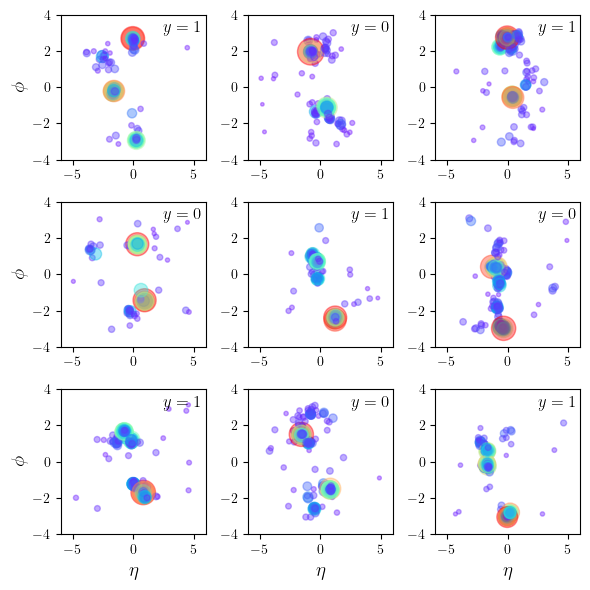

In [60]:
def plot_events(data, ndata=9, ptscale=25, scale=80,
                xmin=-6.0, xmax=6.0,
                ymin=-4.0, ymax=4.0, 
                filename='events.png',
                ftsize=14):

    targets = np.array(data['targets'])
    
    plt.rcParams.update({'font.size': 10})

    # work out number of columns and number of plots
    ncols = 3
    nrows = ndata // ncols
    ndata = nrows * ncols
    fgsize= (2*ncols, 2*nrows)
        
    # create an empty figure
    fig = plt.figure(figsize=fgsize)

    for i in range(ndata):
        index = i+1
        ax = fig.add_subplot(nrows, ncols, index)
        
        # setup axes
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$\eta$', fontsize=ftsize)
        
        if i % ncols == 0:
            ax.set_ylabel(r'$\phi$', fontsize=ftsize)

        # area of points in (y, phi) proportional to pt
        key = f'{i:d}'
        pt, eta, phi = np.array(data[key]).T
        y = targets[i]
        
        size = scale * np.sqrt(pt / ptscale)
        cmap = mp.colormaps['rainbow']
        colors = cmap(size / size.max(), alpha=0.4)

        ax.scatter(eta, phi, s=size, c=colors)

        ax.text(2.5, 3.0, f'$y = {y:d}$', fontsize=12)
    
    fig.tight_layout()
    plt.savefig(filename)
 
plot_events(hdf)

## Plot Distribution of Particle Count

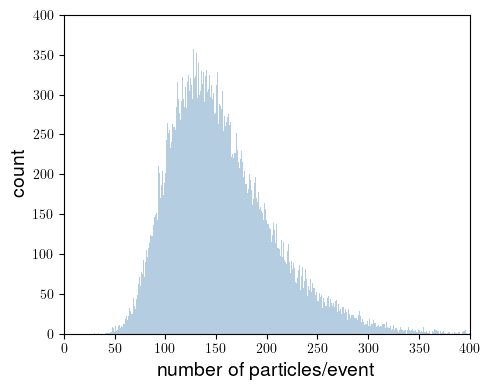

In [5]:
def plot_multiplicity(data, N=36000,
                      xmin=0, xmax=400,
                      ymin=0, ymax=400, 
                      filename='multiplicity.png',
                      fgsize=(5, 4),
                      ftsize=14):

    # create an empty figure
    fig = plt.figure(figsize=fgsize)
    
    nrows, ncols, index = 1, 1, 1
    ax = fig.add_subplot(nrows, ncols, index)
        
    # setup axes
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_xlabel(r'number of particles/event', fontsize=ftsize)

    ax.set_ylabel(r'count', fontsize=ftsize)

    x = [len(data[f'{i:d}']) for i in range(N)]
    ax.hist(x, bins=xmax, range=(xmin, xmax), color='steelblue', alpha=0.4)

    fig.tight_layout()
    plt.savefig(filename)

plot_multiplicity(hdf)

## Prepare Training, Validation, and Test Datasets
  1. Scale data
  2. Split data into training, testing, and validation sets.
  3. Move them to computational device.

In [6]:
scale = torch.Tensor([[200, 5, np.pi]])

X = [event / scale for event in events]

In [7]:
n_train = 30000
n_test  =  5000
n_valid =  len(targets) - n_train - n_test

# split and convert to tensors

train_x, X = X[:n_train],  X[n_train:]
train_y, Y = targets[:n_train], targets[n_train:]

test_x, valid_x = X[:n_test], X[n_test:]
test_y, valid_y = Y[:n_test], Y[n_test:]

print("Size of training set:   %10d" % len(train_x))
print("Size of test set:       %10d" % len(test_x))
print("Size of validation set: %10d" % len(valid_x))

Size of training set:        30000
Size of test set:             5000
Size of validation set:       1000


## Utilities
  1. $\texttt{delta\_phi}$ - computes $\phi_2 - \phi_1$ accounting for the wraparound.
  2. $\texttt{number\_of\_parameters}$ - returns the number of model parameters to be fitted.

In [8]:
def delta_phi(phi2, phi1):
    deltaphi = phi2 - phi1
    abs_deltaphi = torch.abs(deltaphi)
    deltaphi = torch.where(abs_deltaphi > torch.pi, 
                           2 * torch.pi - abs_deltaphi, 
                           abs_deltaphi)
    return deltaphi

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Building a Model as a Python Class

The **nn.Sequential** class is the simplest way to construct (simple) PyTorch models. But if you want more control over the model, you can achieve this by building the model as a class inheriting from **nn.Module** as in the following cell. 

### $\texttt{Edges}$
This computes the adjacency matrix $E \equiv A$ given vertices $V$. An event with $n$ particles can be modeled as a graph with $n$ vertices. Inspired by IceCube, we model the edges of the graph as an $n \times n$ adjacency matrix $A$ where the matrix elements are given by
\begin{align}
    d_{ij} & = \exp(-\alpha \| x_i - x_j \|^2), \\
    A_{ij} & = \texttt{softmax}(d_{ij}, \, \texttt{dim}=1) ,
\end{align}
where $x_i = (\eta_i, \phi_i)$ and $\alpha$ is a free parameter. Following IceCube, the adjacency matrix is not changed by convolution operation, but does of course change from one graph to the next.

In [10]:
class Edges(nn.Module):
    '''
    Given a set of vertices V, compute adjacency matrix of shape (n, n).
    '''    
    def __init__(self, alpha=1, device=DEVICE):

        super().__init__()

        # Note use of Parameter to tell PyTorch that this parameter
        # is to be fitted.
        self.alpha = nn.Parameter(alpha * torch.rand(1))

        self.device = device
        
    def forward(self, x):

        # 1. compute square of Euclidean distance in (eta, phi) space
        #    dR^2 = deta^2 + dphi^2
        eta, phi = x[:, 1], x[:, 2]
        deta = eta.view(-1, 1) - eta.view(1, -1)
        dphi = delta_phi(phi.view(-1, 1), phi.view(1, -1))
        dRdR = deta**2 + dphi**2

        # 2. compute exp(- alpha * dR)**2)
        A = torch.exp(-self.alpha * dRdR)

        # 3. apply softmax in horizontal direction.
        #    adding a unit matrix to the adjacency matrix 
        #    makes the training a bit more stable
        A = torch.softmax(A, dim=1) + torch.eye(len(x)).to(self.device)
        
        return A

### Graph Convolution $\texttt{GCNLayer}$
Here we implement a simple graph convolutional layer from scratch, which differs slightly from the IceCube implementation.
The vertices are concatenated into a matrix, $X$, of shape $(n, d)$. Given a weight matrix $w$ of shape $(h, h)$, where typically $h > d$, and a matrix of ones of shape $(n, h)$ scaled by the bias parameter $b$, the graph convolution operation is defined by
\begin{align}
    X & \leftarrow \sigma(X W^T + B),\\
    X & \leftarrow \sigma((A X) w + b \mathbb{I}) ,
\end{align}
where $\sigma$ is an element-wise nonlinear transformation.

In [11]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_features, out_features, scale=0.05):

        # initialize base class
        super().__init__()

        # we embed the "n" input vertices in a larger vector space
        self.embed  = nn.Linear(in_features, out_features)
        
        self.weight = nn.Parameter(scale * (2*torch.rand(out_features, out_features)-1.0))
        self.bias   = nn.Parameter(scale * (2*torch.rand(1)-1.0))

    def forward(self, X, A):

        # embed vertices in a larger vector space
        X = self.embed(X)
        X = F.relu(X)

        # perform graph convolution. for each vertex, this operation
        # performs a weighted sum of the features of all other vertices,
        # weighting the nearest neighbors more heavily.
        # AX = A * X
        AX = torch.matmul(A, X)

        # compute (A * X) * W + B * I
        X = torch.matmul(AX, self.weight) + self.bias * torch.ones_like(X)
        X = F.relu(X)

        # return modified graph  
        return X

class VerticalSum(nn.Module):
    '''
    Perform a permutation and vertex count-invariant operation on the
    vertices of a graph.
    '''
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        x = x.sum(dim=0)
        return x

### Graph neural network (GNN)

In [12]:
class GNN(nn.Module):
    
    def __init__(self, n_dim, n_width=40):

        # initialize base class
        super().__init__()

        self.edges  = Edges()
        self.gconv1 = GCNLayer(n_dim,   n_width)
        self.gconv2 = GCNLayer(n_width, n_width)
        self.vsum   = VerticalSum()
        self.linear = nn.Linear(n_width, 1)

    def forward(self, x):

        # construct n x n adjacency matrix which together
        # with the vertices V = x forms the graph G = (V, E)
        V = x
        E = self.edges(V)
        
        # pass graph G = (V, E) through multiple
        # graph convolution layers (graph processors)
        V = self.gconv1(V, E)
        V = F.relu(V)
        
        V = self.gconv2(V, E)
        V = F.relu(V)
        
        # apply a permutation- and vertex count-invariant
        # function to the vertices 
        x = self.vsum(V)

        # complete with a simple MLP
        x = self.linear(x)     
        x = F.sigmoid(x)
        
        return x

    def save(self, paramsfile):
        # save parameters of neural network
        torch.save(self.state_dict(), paramsfile)

    def load(self, paramsfile):
        # load parameters of neural network
        self.eval()
        self.load_state_dict(torch.load(paramsfile))

### Define empirical risk (aka average loss)

In [13]:
# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t):
    # f and t must be of the same shape
    # f = torch.where(f >= 1, 0.9999, f)
    losses = torch.where(t > 0.5, torch.log(f), torch.log(1-f))
    return -torch.mean(losses)

### Empirical risk
Ordinarily, the calculation of the empirical risk would leverage the implied loop over batch elements provided by $\texttt{PyTorch}$. However, this requires each batch element to be of the same size. Our implementation of the empiricaal risk computes the loss for each data instance one instance at a time, which of course is much slower. But this is done to account for the fact that the number of points per data instance can vary from one instance to the next. Most of the time, we'll choose a batch size of 1 and a small learning rate.

In [21]:
def empirical_risk(model, lossfn, X, Y):        
    out = model(X[0]) 
    loss = lossfn(out, Y[0])

    for x, y in zip(X[1:], Y[1:]):
        out = model(x)
        loss += lossfn(out, y)
    loss /= len(X)
    return loss

## A Simple Dataloader
This dataloader simply cycles through the training set.

In [22]:
class DataLoader:
    
    def __init__(self, X, T, batch_size):
        self.X = X
        self.T = T
        
        self.B = batch_size
        self.N = len(X)
        
        self.J = 0
        self.A = len(X) / batch_size
        self.J = int(self.A) + 1
        
        self.start = 0
        self.end = B
        self.ii = -1
        
    def __call__(self, ii=-1):

        if ii > self.ii:
            
            # update start and end of batch
                
            self.J += 1
            if self.J >= self.A:
                self.J = 0
                self.start = 0
                self.end = self.B
            else:
                self.start += self.B
                self.end = self.start + self.B
                if self.end > self.N:
                    self.end = self.N

        self.ii = ii
        
        return self.X[self.start:self.end], self.T[self.start:self.end]
        

### Test DataLoader

In [23]:
X = [0,1,2,3,4,5,6]
Y = [0,11,22,33,44,55,66]
B = 3

dataloader = DataLoader(X, Y, B)

for i in range(10):
    x, y = dataloader(i)
    print(f'{i:5d}\t{str(x):10s}\t{str(y):10s}')

print()

for i in range(10):
    x, y = dataloader()
    print(f'{i:5d}\t{str(x):10s}\t{str(y):10s}')


    0	[0, 1, 2] 	[0, 11, 22]
    1	[3, 4, 5] 	[33, 44, 55]
    2	[6]       	[66]      
    3	[0, 1, 2] 	[0, 11, 22]
    4	[3, 4, 5] 	[33, 44, 55]
    5	[6]       	[66]      
    6	[0, 1, 2] 	[0, 11, 22]
    7	[3, 4, 5] 	[33, 44, 55]
    8	[6]       	[66]      
    9	[0, 1, 2] 	[0, 11, 22]

    0	[0, 1, 2] 	[0, 11, 22]
    1	[0, 1, 2] 	[0, 11, 22]
    2	[0, 1, 2] 	[0, 11, 22]
    3	[0, 1, 2] 	[0, 11, 22]
    4	[0, 1, 2] 	[0, 11, 22]
    5	[0, 1, 2] 	[0, 11, 22]
    6	[0, 1, 2] 	[0, 11, 22]
    7	[0, 1, 2] 	[0, 11, 22]
    8	[0, 1, 2] 	[0, 11, 22]
    9	[0, 1, 2] 	[0, 11, 22]


### Train model

In [24]:
def train(model, optimizer, lossfn, 
          t_dataloader, v_dataloader1, v_dataloader2,
          number_iterations,
          lossfile=LOSS_FILE,
          timeleftfile=TIMELEFT_FILE,
          paramsfile=PARAMS_FILE,
          step=100):

    # start saving model parameters after the following number of iterations.
    start_saving = number_iterations // 100
    min_avloss   = float('inf')  # initialize minimum average loss

    # initialize loss file
    # create loss file if it does not exist
    if not os.path.exists(lossfile):
        open(lossfile, 'w').write('iteration,t_loss,v_loss\n')  

    # get last iteration number from loss file
    df = pd.read_csv(lossfile)
    if len(df) < 1:
        itno = 0
    else:
        itno = df.iteration.iloc[-1] # get last iteration number

    # ------------------------------------------
    # enter training loop
    # ------------------------------------------
    timeleft = TimeLeft(number_iterations)
    
    for ii in range(number_iterations):
        
        # set mode to training so that training-specific 
        # operations such as dropout, etc., are enabled.

        model.train() # training mode

        x, y = t_dataloader(ii)
        
        loss = empirical_risk(model, lossfn, x, y)
    
        optimizer.zero_grad()  # clear previous gradients
    
        loss.backward()        # compute gradients
    
        optimizer.step()       # move one step
    
        # i'm alive printout
        
        if (ii % step == 0) and (ii > 0):

            with torch.no_grad():
                
                model.eval()
                
                # compute average loss on train data
                x, y = v_dataloader1()
                t_loss = empirical_risk(model, lossfn, x, y).detach()

                # compute average loss on validation data
                x, y = v_dataloader2()
                v_loss = empirical_risk(model, lossfn, x, y).detach()
     
            # update loss file
            
            open(loss_file, 'a').write(f'{itno:12d},{t_loss:12.8},{v_loss:12.8}\n')

            # save model paramters to file
            
            if v_loss < min_avloss:
                min_avloss = v_loss
                if ii > start_saving:
                    model.save(paramsfile)

            # update time left file
            
            line = f'|{itno:12d}|{t_loss:12.8f}|{v_loss:12.8f}|'
            timeleft(ii, line)
            open(timeleftfile, 'w').write(f'{str(timeleft):s}\n')

            # update iteration number
            
            itno += step

    print()      
    return 

## Instantiate and Train Model

In [25]:
_, n_dimensions = train_x[0].shape

model = GNN(n_dimensions).to(DEVICE)
print('number of parameters:', number_of_parameters(model))

print(model)
print()

for name, p in model.named_parameters():
    if p.requires_grad:
        print(name)
        #print(p)
        #print()

number of parameters: 5044
GNN(
  (edges): Edges()
  (gconv1): GCNLayer(
    (embed): Linear(in_features=3, out_features=40, bias=True)
  )
  (gconv2): GCNLayer(
    (embed): Linear(in_features=40, out_features=40, bias=True)
  )
  (vsum): VerticalSum()
  (linear): Linear(in_features=40, out_features=1, bias=True)
)

edges.alpha
gconv1.weight
gconv1.bias
gconv1.embed.weight
gconv1.embed.bias
gconv2.weight
gconv2.bias
gconv2.embed.weight
gconv2.embed.bias
linear.weight
linear.bias


In [26]:
loss_file = LOSS_FILE
timeleft_file = TIMELEFT_FILE
params_file = PARAMS_FILE

n_iterations = 200001
n_batch = 1
step = 100
learning_rate = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

avloss = average_cross_entropy_loss

t_dataloader  = DataLoader(train_x, train_y, n_batch)
v_dataloader1 = DataLoader(train_x, train_y, n_valid)
v_dataloader2 = DataLoader(valid_x, valid_y, n_valid)

In [20]:
DELETE_LOSS_FILE = True

if DELETE_LOSS_FILE:
    os.system(f'rm -f {loss_file:s}')

train(model, optimizer, avloss, 
      t_dataloader, v_dataloader1, v_dataloader2, 
      n_iterations,
      loss_file, timeleft_file, params_file, 
      step)

    200001|100.00%|00:14:57/00:00:00| 222.9 it/s|      199900|  0.30926517|  0.26799062|



In [41]:
def plot_confusion_matrix(y_pred, y, gfile='confusion_matrix.png'):
    
    from sklearn.metrics import confusion_matrix
    
    # Calculate the confusion matrix

    conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred)

    # plot the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(conf_matrix, cmap=plt.cm.rainbow, alpha=0.4)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], 
                    va='center', ha='center', size='x-large')
 
    plt.xlabel('Predicted Labels', fontsize=16)
    plt.ylabel('True Labels', fontsize=16)
    plt.title(f'Confusion Matrix', fontsize=16)
    fig.tight_layout()
    plt.savefig(gfile)
    plt.show()

In [43]:
model.load(params_file)

y_hat = []
for i in tqdm(range(len(test_x))):
    y_hat.append(float(model(test_x[i]).data.cpu()))

y_hat  = np.array(y_hat)
y_pred = (y_hat > 0.5).astype(int)
y_true = test_y.data.cpu().numpy()

100%|██████████████████████████████████████| 5000/5000 [00:09<00:00, 510.37it/s]


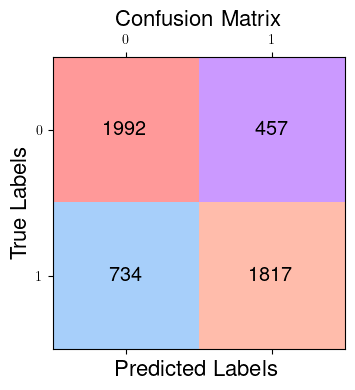

In [44]:
plot_confusion_matrix(y_pred, y_true)

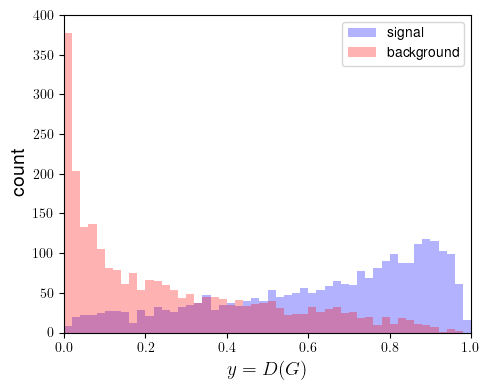

In [56]:
def plot_outputs(yhat, y, 
                      xbins=50, xmin=0, xmax=1,
                      ymin=0, ymax=400, 
                      filename='outputs.png',
                      fgsize=(5, 4),
                      ftsize=14):

    # create an empty figure
    fig = plt.figure(figsize=fgsize)
    
    nrows, ncols, index = 1, 1, 1
    ax = fig.add_subplot(nrows, ncols, index)
        
    # setup axes
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_xlabel(r'$y = D(G)$', fontsize=ftsize)

    ax.set_ylabel(r'count', fontsize=ftsize)

    s = yhat[y > 0.5]
    b = yhat[y < 0.5]
    ax.hist(s, bins=xbins, range=(xmin, xmax), color='blue', alpha=0.3, label='signal')
    ax.hist(b, bins=xbins, range=(xmin, xmax), color='red', alpha=0.3, label='background')
    ax.legend()
    
    fig.tight_layout()
    plt.savefig(filename)

plot_outputs(y_hat, y_true)